In [19]:
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)


def format_ticks(x, pos):
    return str(int(x / 1000))


wandb.login()
api = wandb.Api()

In [20]:
tiny_lora = api.run("pico-lm/pico-relora/ixdq4sof")
small_lora = api.run("pico-lm/pico-relora/a8nvp3mi")
tiny_base = api.run("pico-lm/pico-relora/rpfgrgc4")
small_base = api.run("pico-lm/pico-relora/vmyjbapv")

In [21]:
data = {
    "lora": {
        "tiny": pd.DataFrame(tiny_lora.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_lora.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
    "base": {
        "tiny": pd.DataFrame(tiny_base.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_base.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
}

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_53990/3679100403.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)
/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_53990/3679100403.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)


In [22]:
def get_across_ranges(
    df: pd.DataFrame, metric_name: str, step_mod: int = 1, step_mod_offset: int = 0, *ranges
):
    if not ranges:
        ranges = (range(12),)
    combos = product(*ranges)
    df = df.drop_duplicates(subset=["_step"], inplace=False)
    mask = df["_step"] % step_mod == step_mod_offset
    df = df[mask]
    x = [df[metric_name.format(*combo)].replace("NaN", np.nan).to_numpy() for combo in combos]
    return np.column_stack(x)

In [23]:
STEP_MOD = 2_000

In [24]:
MODS = ("swiglu.w_2", "attention.v_proj", "attention.o_proj")

In [29]:
def _get_per_data():
    for mod_idx, mod in enumerate(MODS):
        for t in data:
            for s in data[t]:
                metr_str = (
                    "per_val/_forward_module.module.layers.{}"
                    + f".{mod}{'.lora' if t == 'lora' else ''}."
                    + ("weights" if t == "lora" else "gradients")
                )
                val = get_across_ranges(
                    data[t][s], metr_str, step_mod=2_000, step_mod_offset=0 if t == "base" else 100
                )
                for ckp_id, ckp in enumerate(val):
                    for lay_id, layer_val in enumerate(ckp):
                        yield (
                            [r"Swiglu $W_2$", r"Attention Value Projection", r"Attention Output Projection"][
                                mod_idx
                            ],
                            rf"\texttt{{pico-{'decoder' if t == 'base' else 'relora'}}}",
                            s,
                            int(ckp_id * 2),
                            lay_id,
                            layer_val,
                        )


per_data = pd.DataFrame(
    _get_per_data(),
    columns=["Component", "Model", "Scale", "Step", "Layer", "PER"],
)

In [26]:
per_data

,Component,Model,Scale,Step,Layer,PER
0,Swiglu $W_2$,\texttt{pico-relora},tiny,0,0,NaN
1,Swiglu $W_2$,\texttt{pico-relora},tiny,0,1,NaN
2,Swiglu $W_2$,\texttt{pico-relora},tiny,0,2,NaN
3,Swiglu $W_2$,\texttt{pico-relora},tiny,0,3,NaN
4,Swiglu $W_2$,\texttt{pico-relora},tiny,0,4,NaN
...,...,...,...,...,...,...
1579,Attn O Proj,\texttt{pico-decoder},small,20,7,0.256437
1580,Attn O Proj,\texttt{pico-decoder},small,20,8,0.204340
1581,Attn O Proj,\texttt{pico-decoder},small,20,9,0.215211
1582,Attn O Proj,\texttt{pico-decoder},small,20,10,0.269692


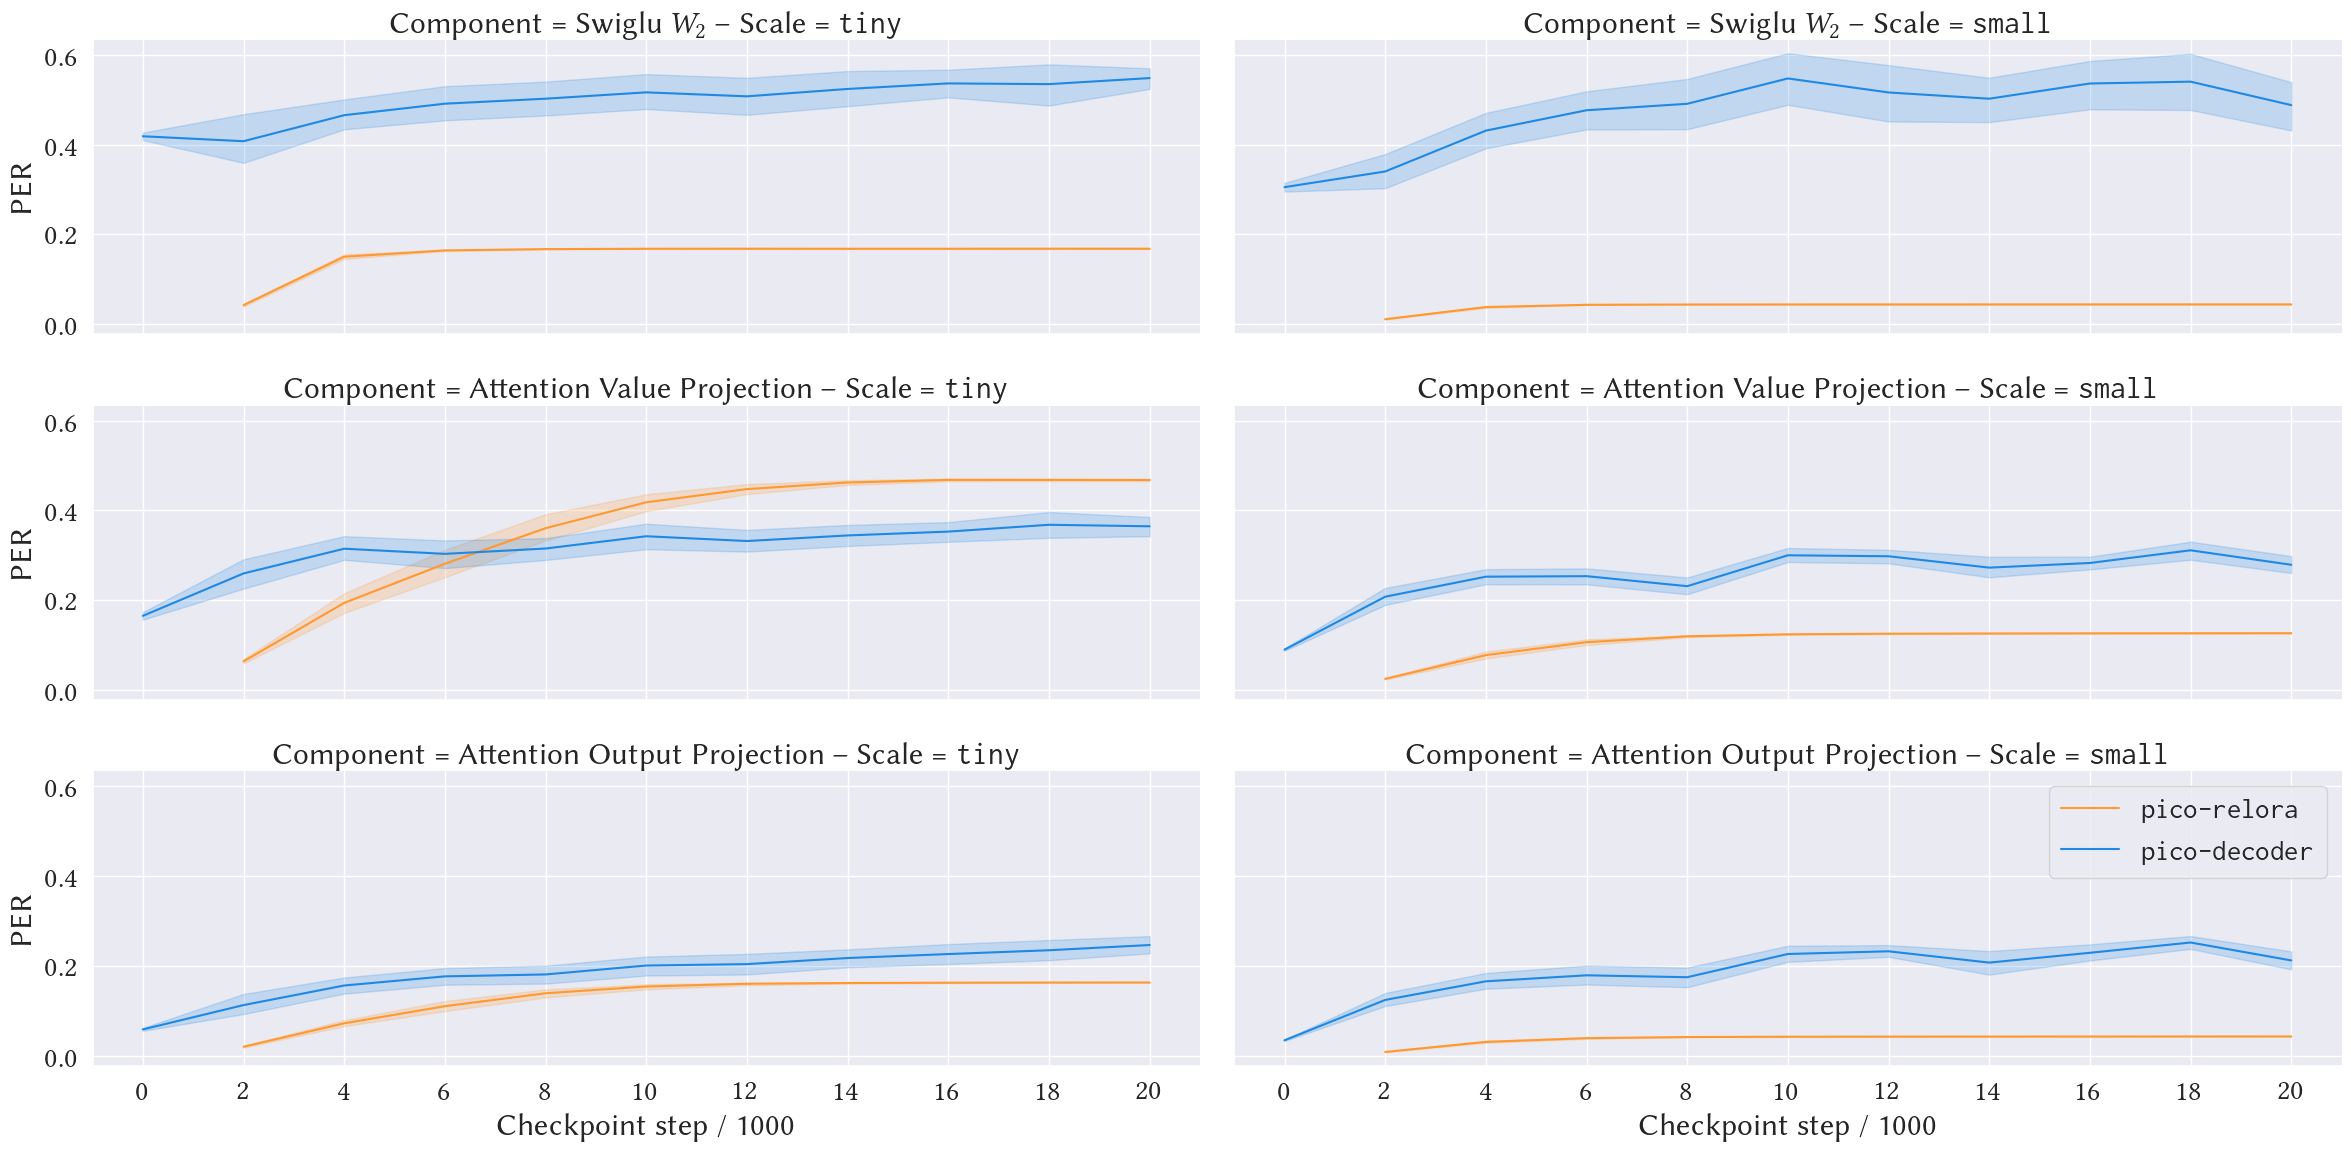

In [31]:
colors = ["#1E88E5", "#FF992F"]
models = sorted(per_data["Model"].unique().tolist())
palette = dict(zip(models, colors))

dodge = 0.4
size = 8
font_scale = 1.9

sns.set_theme(font_scale=font_scale, rc={"axes.grid": "True", "axes.grid.which": "both"})

g = sns.FacetGrid(
    data=per_data,
    col="Scale",
    row="Component",
    height=4,
    aspect=3,
    sharey=True,
    sharex=True,
    margin_titles=False,
)

g.set_titles(template=r"Component = {row_name} -- Scale = \texttt{{{col_name}}}")


g.map_dataframe(sns.lineplot, x="Step", y="PER", hue="Model", palette=palette, markers=["s", "o"])

g.set_axis_labels("Checkpoint step / 1000", "PER")

g.set_ylabels()

for idx, ax in enumerate(g.axes.flat):
    steps = per_data["Step"].unique()
    ax.set_xticks(steps)
    if idx == 5:
        ax.legend(bbox_to_anchor=(1, 1), loc="upper right")

plt.savefig("../graphs/per-grads.pdf")
plt.show()